# Proyek Analisis Data: Nama dataset
- Nama: Clara Carissa
- Email: rissa0703.cc@gmail.com
- Id Dicoding: clara_carissa_7cho

## Menentukan Pertanyaan Bisnis

- Di musim apa sepeda paling banyak dan paling sedikit dipinjam?
- Di pukul berapa sepeda paling banyak dan paling sedikit dipinjam?
- Bagaimana rata-rata peminjaman sepeda setiap harinya?
- Bagaimana performa peminjaman sepeda oleh pengguna yang terdaftar (Registered) tiap bulannya di tahun 2011 - 2012?

## Menyiapkan semua library yang dibutuhkan

In [ ]:
#Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Data Wrangling

### Gathering Data

In [2]:
#Load Day Dataset
day_df = pd.read_csv('/content/day.csv')
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
#Load Hour Dataset
hour_df = pd.read_csv('/content/hour.csv')
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Assessing Data

**Day**

In [4]:
#Get information (number of columns, column labels, data types, memory usage, range index, and the number of cells) from day dataframe
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [5]:
#Check whether day dataframe contains missing or null value
day_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
#Check duplicate value in day dataframe
print("Jumlah duplikasi: ", day_df.duplicated().sum())

Jumlah duplikasi:  0


In [7]:
#Returns description of day dataframe
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [ ]:
#Returns description of day dataframe
day_df.describe(include=object)

,dteday
count,731
unique,731
top,2012-12-31
freq,1


**Hour**

In [8]:
#Get information (number of columns, column labels, data types, memory usage, range index, and the number of cells) from hour dataframe
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [9]:
##Check whether hour dataframe contains missing or null value
hour_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [10]:
#Check duplicate value in hour dataframe
print("Jumlah duplikasi: ", hour_df.duplicated().sum())

Jumlah duplikasi:  0


In [11]:
##Returns description of day dataframe
hour_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [ ]:
#Returns description of day dataframe
hour_df.describe(include=object)

,dteday
count,17379
unique,731
top,2012-12-31
freq,24


### Cleaning Data

**Day**

In [12]:
#Change dteday column Data Type
datetime_columns = ["dteday"]

for column in datetime_columns:
  day_df[column] = pd.to_datetime(day_df[column])

In [13]:
#Check whether data type of dteday column has been changed
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [14]:
day_df.to_csv("day_clean.csv", index=False)

**Hour**

In [15]:
#Change dteday column Data Type
datetime_columns = ["dteday"]

for column in datetime_columns:
  hour_df[column] = pd.to_datetime(hour_df[column])

In [16]:
#Check whether data type of dteday column has been changed
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [17]:
hour_df.to_csv("hour_clean.csv", index=False)

### Checking Outliers

**Day**

In [ ]:
day_column =["temp", "atemp", "hum", "windspeed"]

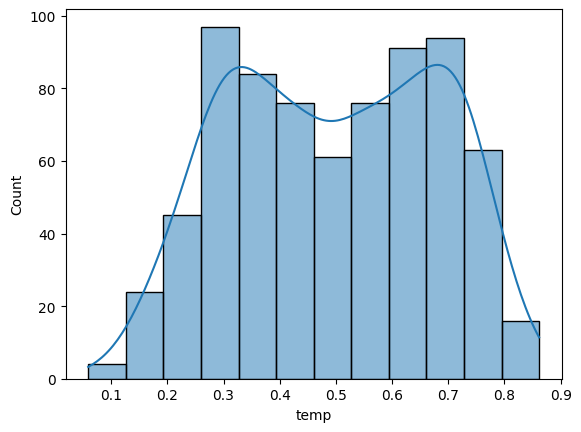

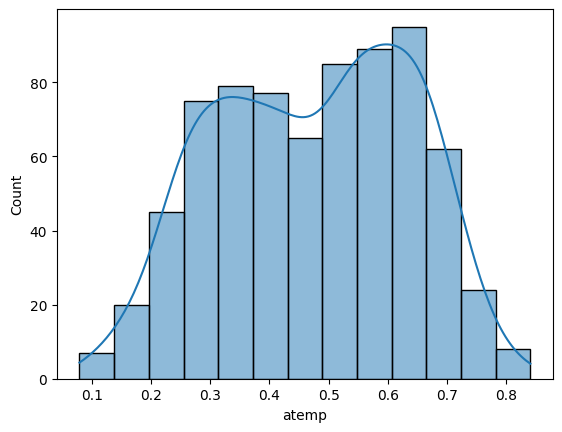

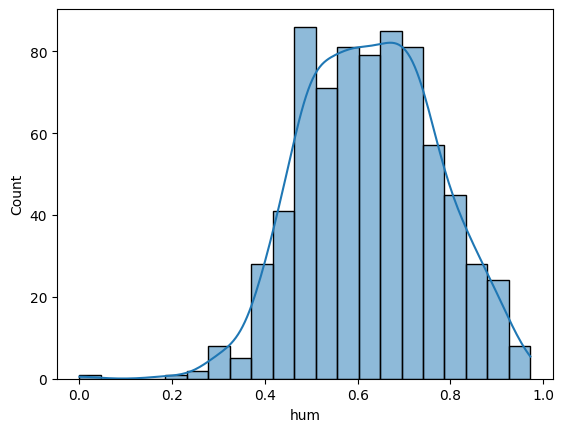

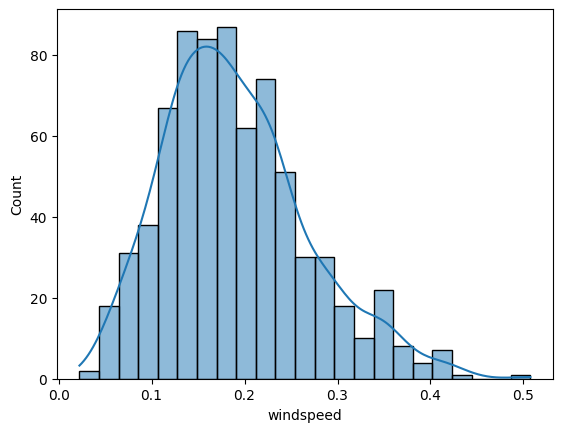

In [ ]:
for column in day_column:
    sns.histplot(day_df[column], kde=True)
    plt.show()

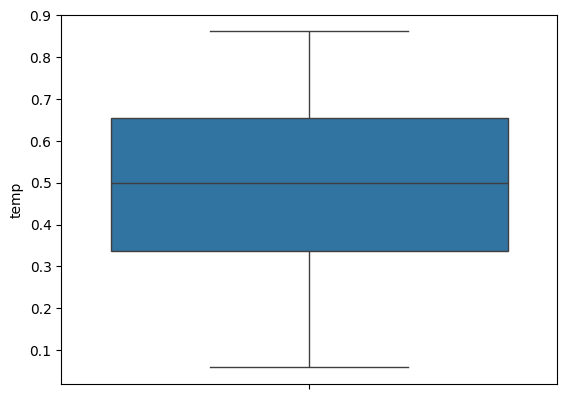

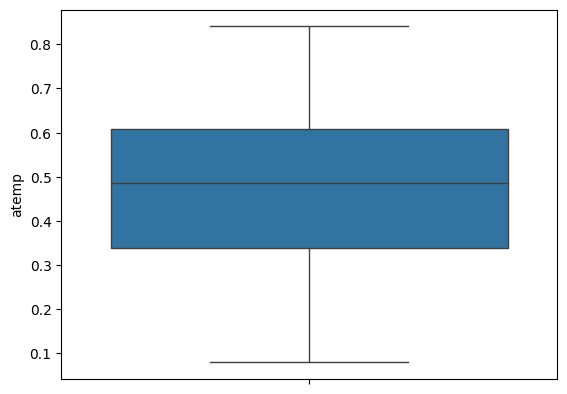

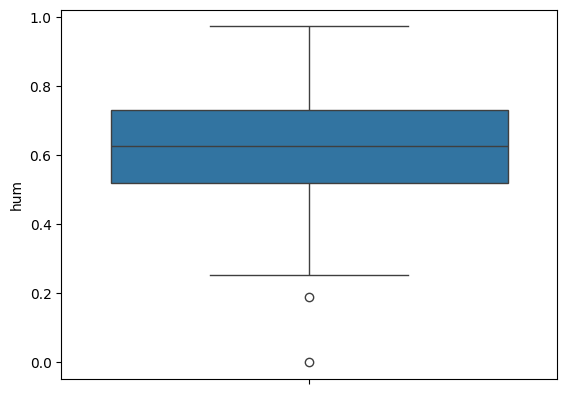

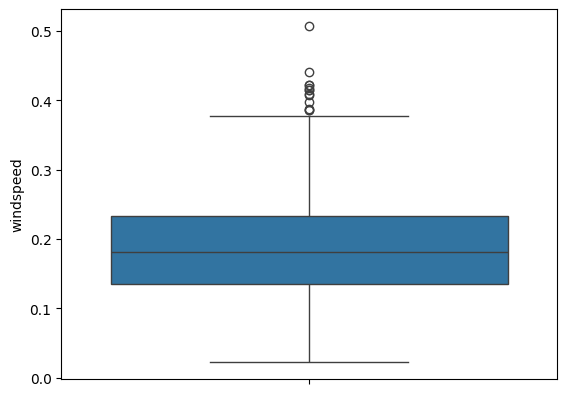

In [ ]:
for column in day_column:
    sns.boxplot(day_df[column])
    plt.show()

Berdasarkan grafik boxplot di atas dapat diketahui bahwa terdapat outlier pada fitur atau kolom 'hum' dan 'windspeed'. Pada kolom 'hum' atau humidity nilai outlier berada pada titik 0.0 dan 0.2. Yang mana tingkat kelembapan udara sebesar 0 adalah hal yang tidak mungkin terjadi di dunia nyata karena jejak uap air di udara akan selalu ada meskipun di daerah yang sangat kering, sehingga 'hum' sebesar 0 sajalah yang akan dihilangkan. Oleh karena itu, outlier ini perlu dihilangkan dengan metode IQR karena distribusi data dari kolom 'hum' tidak normal (skewed ke kanan). Kemudian, pada kolom 'windspeed' nilai outlier berada pada rentang hampir mencapai 0.4 hingga 0.5. Outlier ini tidak dihilangkan karena kecepatan angin senilai 0.5 masih tergolong tenang.

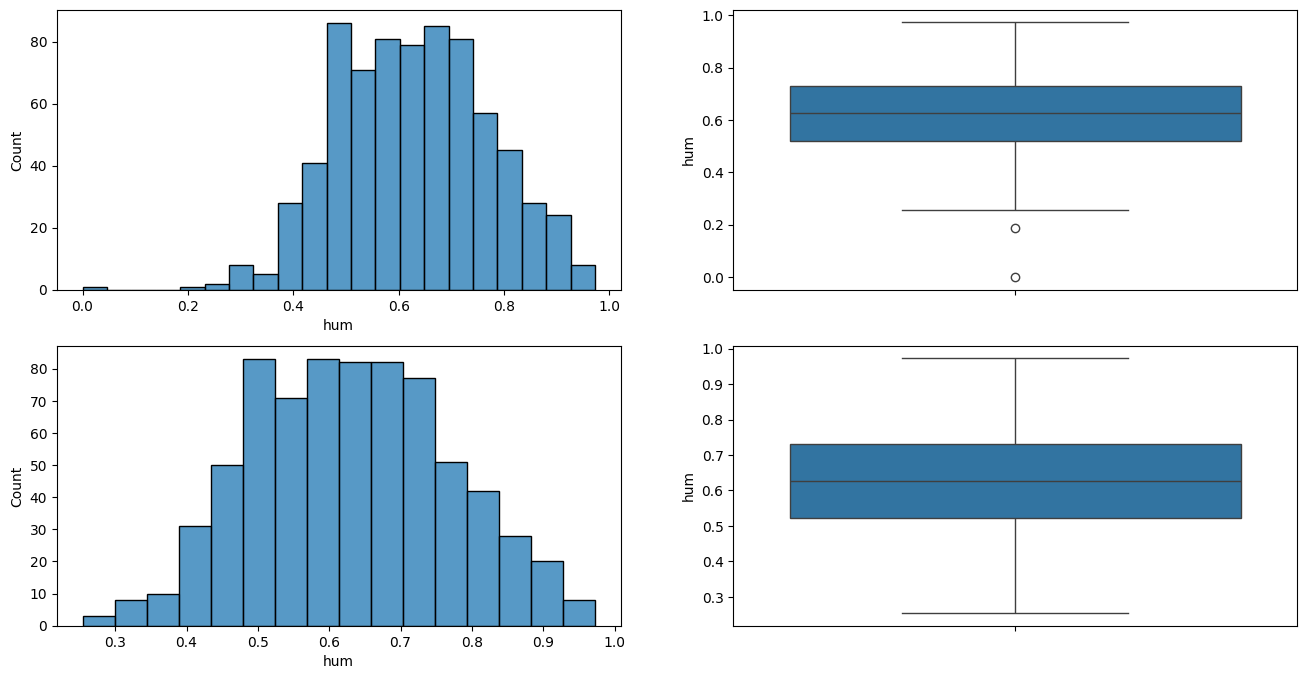

In [ ]:
Q1 = day_df['hum'].quantile(0.25)
Q3 = day_df['hum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

new_df = day_df[(day_df['hum'] >= lower_bound) & (day_df['hum'] <= upper_bound)]
new_df.shape

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(day_df['hum'])
plt.subplot(2,2,2)
sns.boxplot(day_df['hum'])
plt.subplot(2,2,3)
sns.histplot(new_df['hum'])
plt.subplot(2,2,4)
sns.boxplot(new_df['hum'])
plt.show()

**Hour**

In [ ]:
hour_column =["temp", "atemp", "hum", "windspeed"]

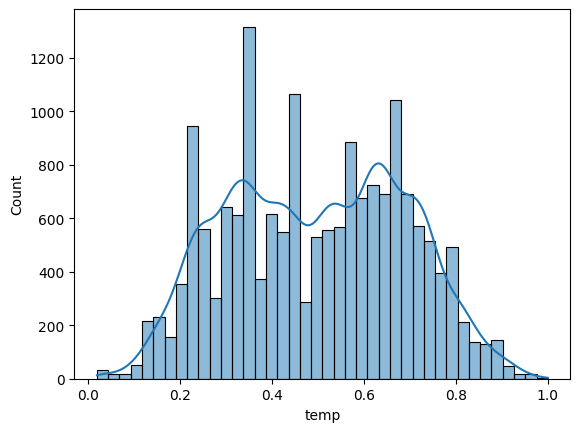

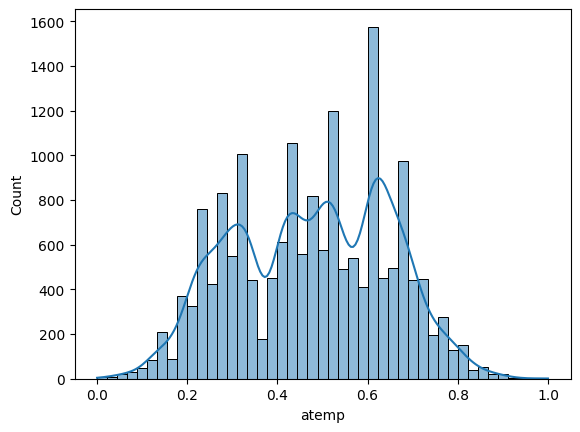

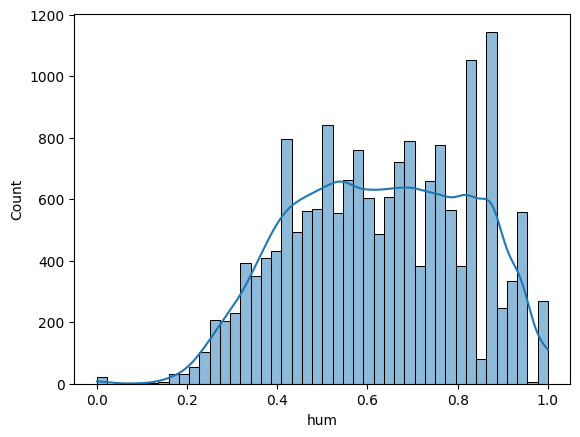

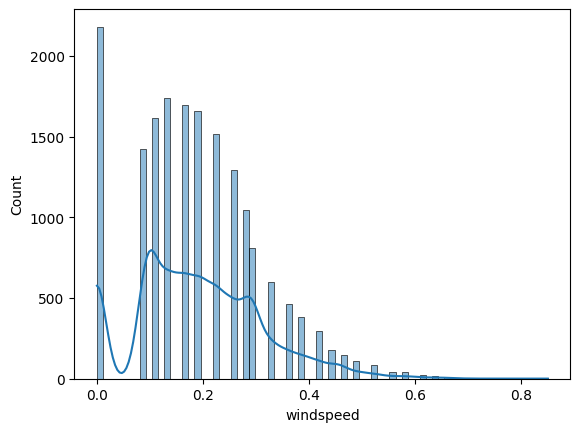

In [ ]:
for column in hour_column:
    sns.histplot(hour_df[column], kde=True)
    plt.show()

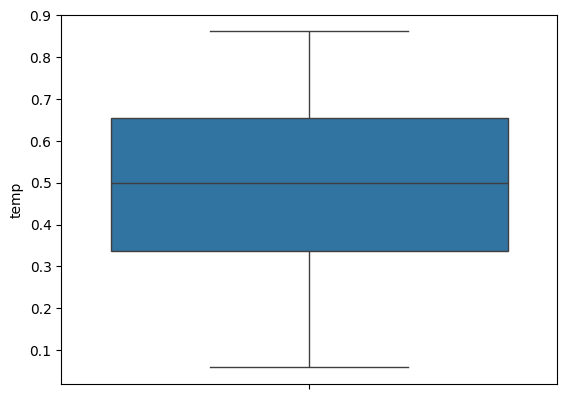

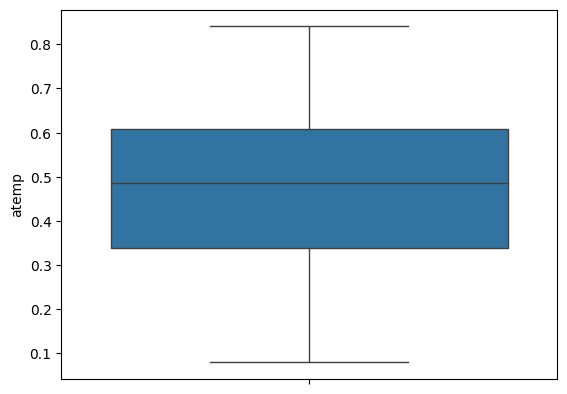

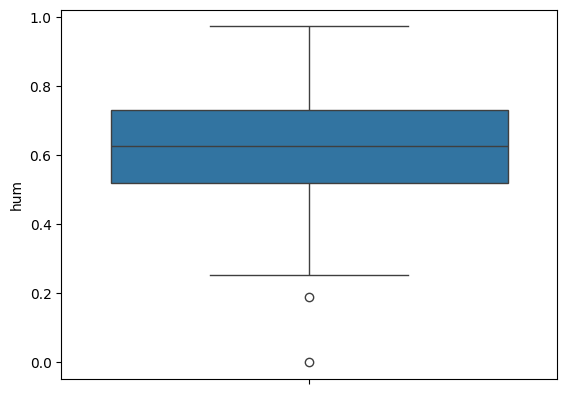

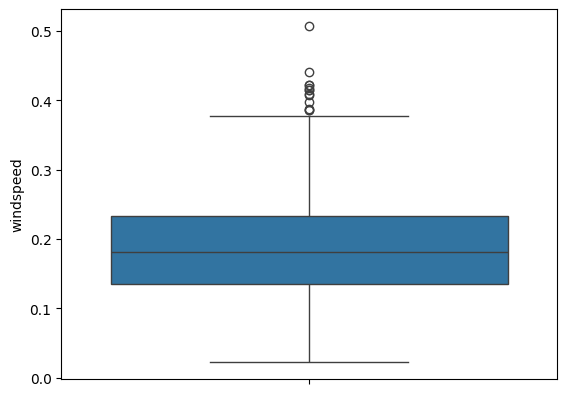

In [ ]:
for column in day_column:
    sns.boxplot(day_df[column])
    plt.show()

Sama halnya seperti day_df, pada hour_df berdasarkan grafik boxplot di atas dapat diketahui bahwa terdapat outlier pada fitur atau kolom 'hum' dan 'windspeed'. Pada kolom 'hum' atau humidity nilai outlier berada pada titik 0.0 dan 0.2. Yang mana tingkat kelembapan udara sebesar 0 adalah hal yang tidak mungkin terjadi di dunia nyata karena jejak uap air di udara akan selalu ada meskipun di daerah yang sangat kering, sehingga 'hum' sebesar 0 sajalah yang akan dihilangkan. Oleh karena itu, outlier ini perlu dihilangkan dengan metode IQR karena distribusi data dari kolom 'hum' tidak normal (skewed ke kanan). Kemudian, pada kolom 'windspeed' nilai outlier berada pada rentang hampir mencapai 0.4 hingga 0.5. Outlier ini tidak dihilangkan karena kecepatan angin senilai 0.5 masih tergolong tenang.

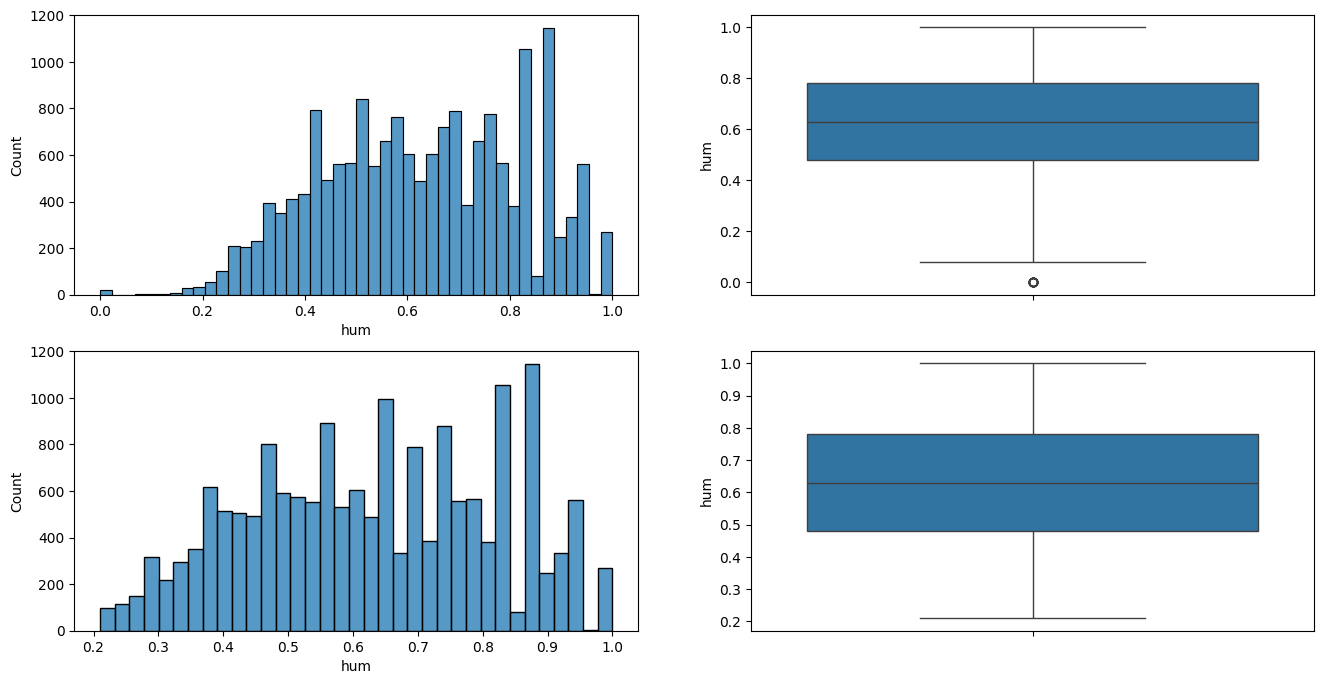

In [ ]:
Q1_hour = hour_df['hum'].quantile(0.25)
Q3_hour = hour_df['hum'].quantile(0.75)
IQR_hour = Q3 - Q1
lower_bound_hour = Q1 - 1.5 * IQR
upper_bound_hour = Q3 + 1.5 * IQR

new_df_hour = hour_df[(hour_df['hum'] >= lower_bound) & (hour_df['hum'] <= upper_bound)]
new_df_hour.shape

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(hour_df['hum'])
plt.subplot(2,2,2)
sns.boxplot(hour_df['hum'])
plt.subplot(2,2,3)
sns.histplot(new_df_hour['hum'])
plt.subplot(2,2,4)
sns.boxplot(new_df_hour['hum'])
plt.show()

## Exploratory Data Analysis (EDA)

### Explore Day DataFrame

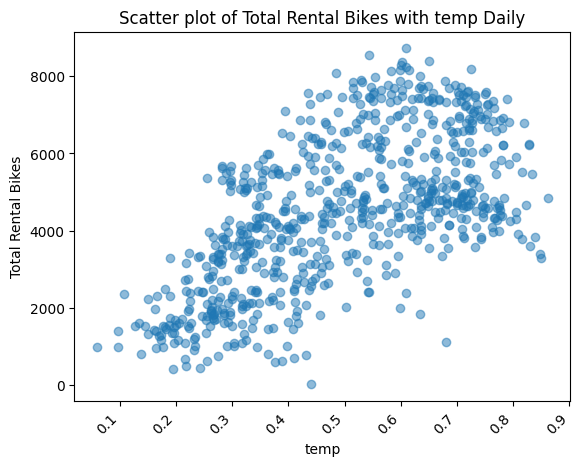

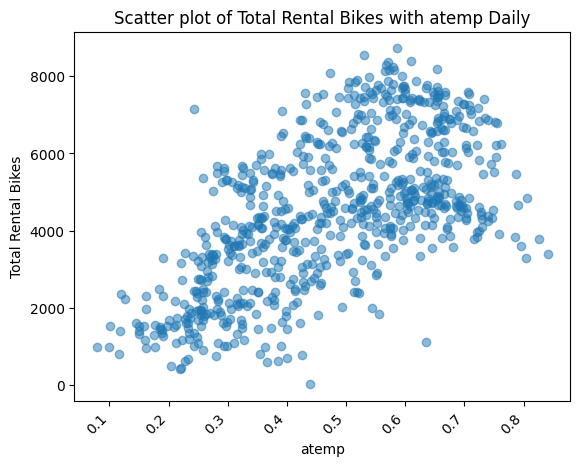

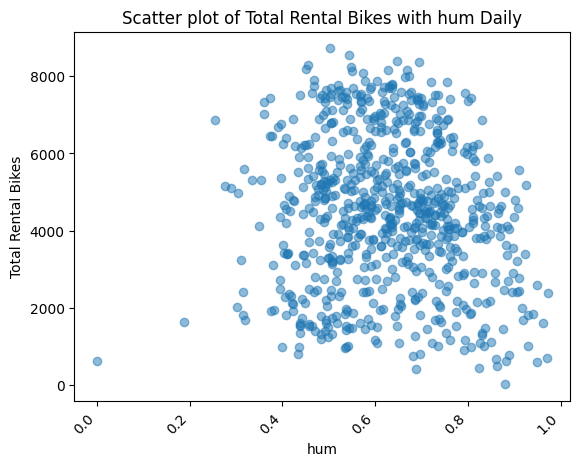

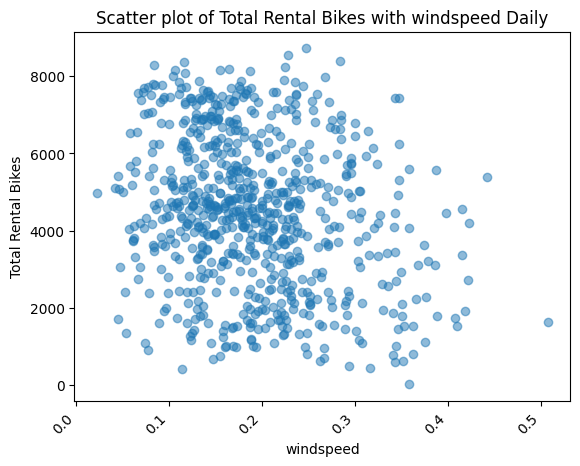

In [ ]:
for feature in day_column:
    counts = day_df.groupby([feature, 'cnt'])['cnt'].count().reset_index(name='Counts')

    plt.scatter(data=day_df, x=feature, y='cnt', alpha=0.5)
    plt.title(f"Scatter plot of Total Rental Bikes with {feature} Daily")
    plt.xlabel(f"{feature}")
    plt.ylabel("Total Rental Bikes")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [18]:
#Change label of season by adding new column called season_new
day_df["season_new"] = day_df.season.apply(lambda x: "Spring" if x == 1 else ("Summer" if x == 2 else ("Fall" if x == 3 else "Winter")))

In [19]:
#Make pivot table by season_new
day_df.groupby(by=["season_new"]).agg({
    "casual": "sum",
    "registered": "sum",
    "cnt": "sum"
})

,casual,registered,cnt
season_new,,,
Fall,226091,835038,1061129
Spring,60622,410726,471348
Summer,203522,715067,918589
Winter,129782,711831,841613


In [20]:
#Change label of weekday by adding new column called weekday_new
day_df["weekday_new"] = day_df.weekday.apply(lambda x: "Sunday" if x == 0 else ("Monday" if x == 1 else ("Tuesday" if x == 2 else ("Wednesday" if x == 3
                                              else ("Thursday" if x == 4 else ("Friday" if x == 5 else "Saturday"))))))

In [21]:
#Get top 5 column of day dataframe
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_new,weekday_new
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,Spring,Saturday
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,Spring,Sunday
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,Spring,Monday
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,Spring,Tuesday
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,Spring,Wednesday


In [22]:
#Make pivot table by weekday_new
day_df.groupby(by=["weekday_new"]).agg({
    "casual": "mean",
    "registered": "mean",
    "cnt": "mean"
})

,casual,registered,cnt
weekday_new,,,
Friday,752.288462,3938.000000,4690.288462
Monday,674.133333,3663.990476,4338.123810
Saturday,1465.257143,3085.285714,4550.542857
Sunday,1338.295238,2890.533333,4228.828571
Thursday,590.961538,4076.298077,4667.259615
Tuesday,556.182692,3954.480769,4510.663462
Wednesday,551.144231,3997.394231,4548.538462


In [23]:
#Get year only from dteday column and make it new column called Year
day_df['Year'] = day_df['dteday'].dt.strftime('%Y')
day_df['Year'].head()

0    2011
1    2011
2    2011
3    2011
4    2011
Name: Year, dtype: object

In [24]:
#Make pivot table by year and month
yr_mnth_df=day_df.groupby(by=["Year", "mnth"]).agg({
                  "casual": "sum",
                  "registered": "sum",
                  "cnt": "sum"
            })

yr_mnth_df.head()

casual  registered     cnt
Year mnth                            
2011 1       3073       35116   38189
     2       6242       41973   48215
     3      12826       51219   64045
     4      22346       72524   94870
     5      31050      104771  135821

### Explore Hour DataFrame

In [25]:
#Make pivot table by hour
hour_df.groupby(by=["hr"]).agg({
    "casual": "sum",
    "registered": "sum",
    "cnt": "sum"
})

,casual,registered,cnt
hr,,,
0,7375,31755,39130
1,4709,19455,24164
2,3412,12940,16352
3,1893,6281,8174
4,874,3554,4428
5,1012,13249,14261
6,3017,52115,55132
7,8037,146134,154171
8,15761,245240,261001


In [26]:
#Change label of weekday by adding new column called weekday_new
hour_df["weekday_new"] = hour_df.weekday.apply(lambda x: "Sunday" if x == 0 else ("Monday" if x == 1 else ("Tuesday" if x == 2 else ("Wednesday" if x == 3
                                              else ("Thursday" if x == 4 else ("Friday" if x == 5 else "Saturday"))))))

In [27]:
#Get top 5 rows of hour dataframe
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday_new
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,Saturday
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,Saturday
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,Saturday
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,Saturday
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,Saturday


## Visualization & Explanatory Analysis

### Pertanyaan 1: Di musim apa sepeda paling banyak dan paling sedikit dipinjam?

In [28]:
# Create pivot table based on EDA to make visualization
sum_season_df = day_df.groupby("season_new").cnt.sum().sort_values(ascending=False).reset_index()
sum_season_df.head()

,season_new,cnt
0,Fall,1061129
1,Summer,918589
2,Winter,841613
3,Spring,471348


<ipython-input-29-60a0162aeaab>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cnt", y="season_new", data=sum_season_df.sort_values(by="cnt", ascending=False), palette=colors, ax=ax[0])
<ipython-input-29-60a0162aeaab>:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(x="cnt", y="season_new", data=sum_season_df.sort_values(by="cnt", ascending=False), palette=colors, ax=ax[0])
<ipython-input-29-60a0162aeaab>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cnt", y="season_new", data=sum_season_df.sort_values(by="cnt", ascending=True), palette=colors, ax=ax[1])
<ipython-input-29-60a0162aeaab>:12: UserWarning: The palette li

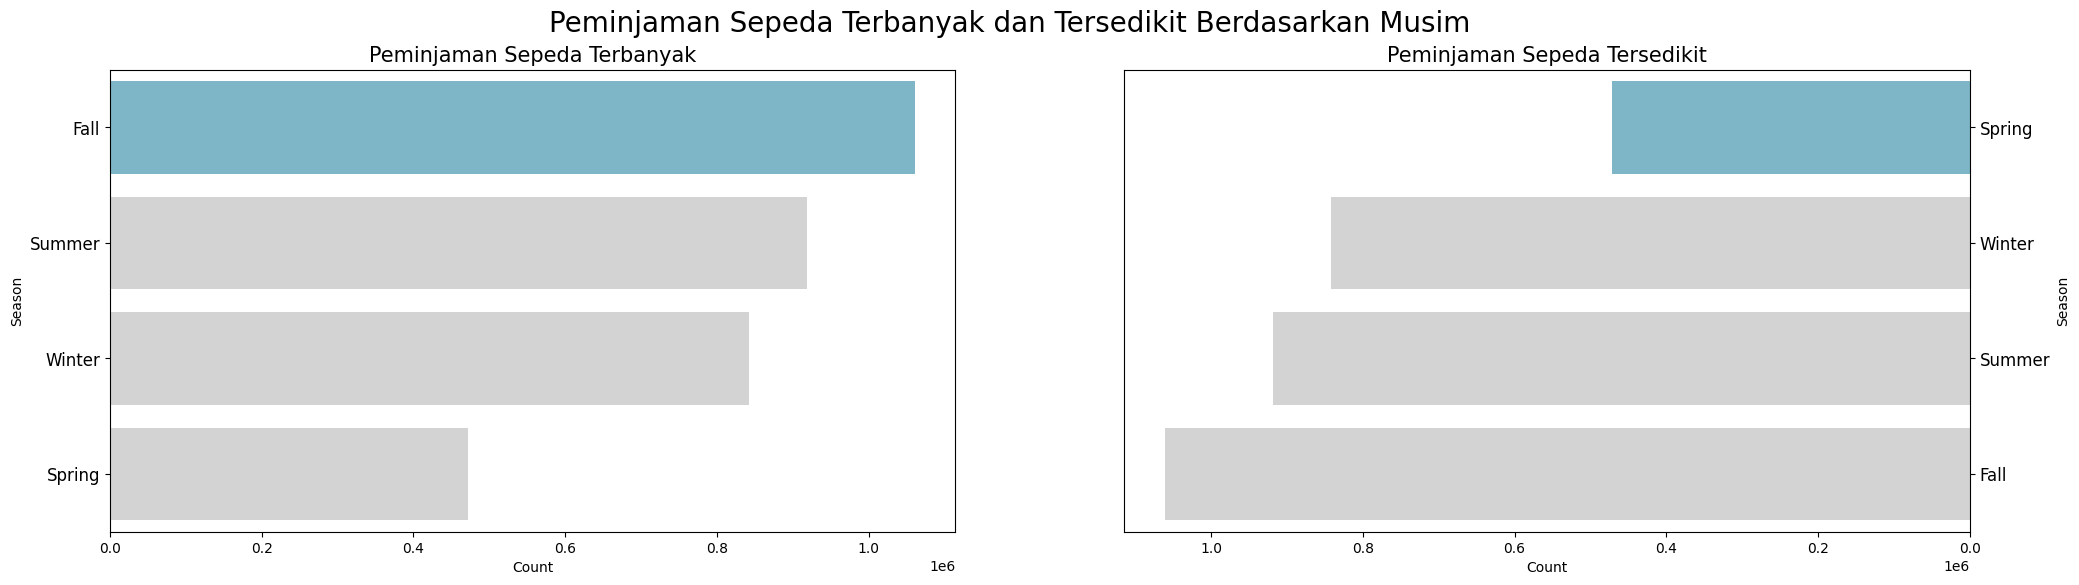

In [29]:
# Create visualization for the question
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(x="cnt", y="season_new", data=sum_season_df.sort_values(by="cnt", ascending=False), palette=colors, ax=ax[0])
ax[0].set_ylabel("Season", size=10)
ax[0].set_xlabel("Count", size=10)
ax[0].set_title("Peminjaman Sepeda Terbanyak", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

sns.barplot(x="cnt", y="season_new", data=sum_season_df.sort_values(by="cnt", ascending=True), palette=colors, ax=ax[1])
ax[1].set_ylabel("Season", size=10)
ax[1].set_xlabel("Count", size=10)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Peminjaman Sepeda Tersedikit", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Peminjaman Sepeda Terbanyak dan Tersedikit Berdasarkan Musim", fontsize=20)
plt.show()

### Pertanyaan 2: Di pukul berapa sepeda paling banyak dan paling sedikit dipinjam?

In [30]:
# Create pivot table based on EDA to make visualization
sum_hr_df = hour_df.groupby("hr").cnt.sum().sort_values(ascending=False).reset_index()
sum_hr_df.head()

,hr,cnt
0,17,336860
1,18,309772
2,8,261001
3,16,227748
4,19,226789


<ipython-input-31-c9a59a67da36>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hr", y="cnt", data=sum_hr_df.sort_values(by="cnt", ascending=False).head(5), palette=coolors, ax=ax[0])
<ipython-input-31-c9a59a67da36>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="hr", y="cnt", data=sum_hr_df.sort_values(by="cnt", ascending=True).head(5), palette=coolorss, ax=ax[1])


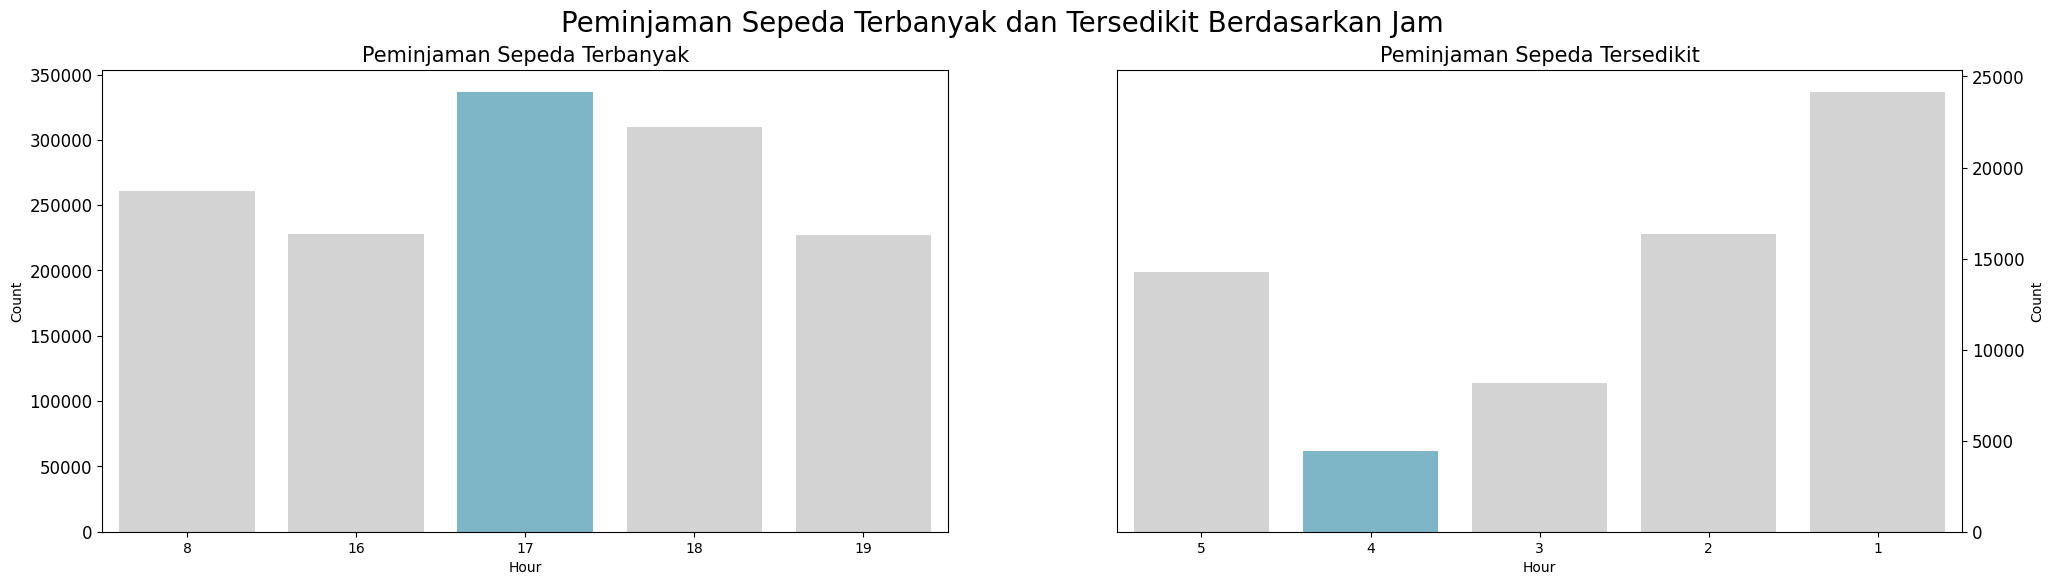

In [31]:
# Create visualization for the question
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

coolors = ["#D3D3D3", "#D3D3D3", "#72BCD4", "#D3D3D3", "#D3D3D3"]
coolorss = ["#D3D3D3", "#D3D3D3", "#D3D3D3", "#72BCD4", "#D3D3D3"]

sns.barplot(x="hr", y="cnt", data=sum_hr_df.sort_values(by="cnt", ascending=False).head(5), palette=coolors, ax=ax[0])
ax[0].set_ylabel("Count", size=10)
ax[0].set_xlabel("Hour", size=10)
ax[0].set_title("Peminjaman Sepeda Terbanyak", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

sns.barplot(x="hr", y="cnt", data=sum_hr_df.sort_values(by="cnt", ascending=True).head(5), palette=coolorss, ax=ax[1])
ax[1].set_ylabel("Count", size=10)
ax[1].set_xlabel("Hour", size=10)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Peminjaman Sepeda Tersedikit", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Peminjaman Sepeda Terbanyak dan Tersedikit Berdasarkan Jam", fontsize=20)
plt.show()

### Pertanyaan 3: Bagaimana rata-rata peminjaman sepeda tiap harinya?

In [32]:
# Create pivot table based on EDA to make visualization
weekday_df = day_df.groupby("weekday_new").cnt.mean().sort_values(ascending=False).reset_index()
weekday_df.head()

,weekday_new,cnt
0,Friday,4690.288462
1,Thursday,4667.259615
2,Saturday,4550.542857
3,Wednesday,4548.538462
4,Tuesday,4510.663462


<ipython-input-33-b10dc18d0158>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


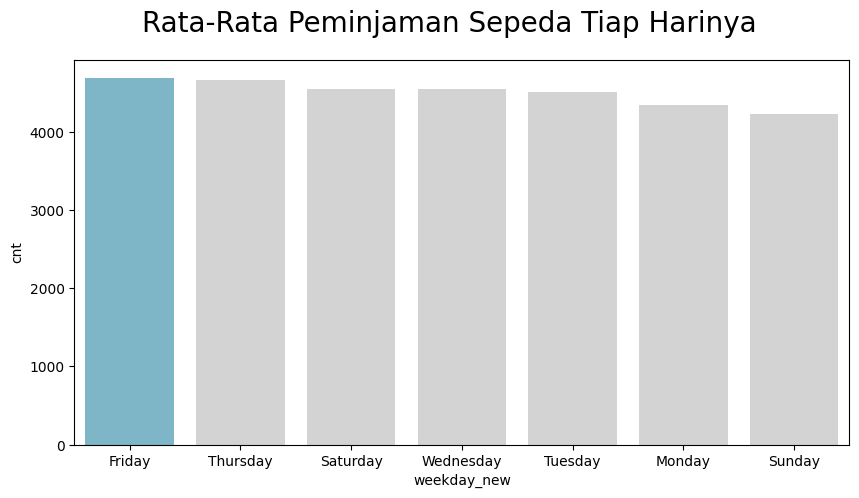

In [33]:
# Create visualization for the question
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
plt.figure(figsize=(10, 5))

sns.barplot(
    x="weekday_new",
    y="cnt",
    data=weekday_df.sort_values(by="cnt", ascending=False),
    palette=colors)

plt.suptitle("Rata-Rata Peminjaman Sepeda Tiap Harinya", fontsize=20)
plt.show()

### Pertanyaan 4: Bagaimana performa peminjaman sepeda oleh pengguna yang terdaftar tiap bulannya di tahun 2011 - 2012?


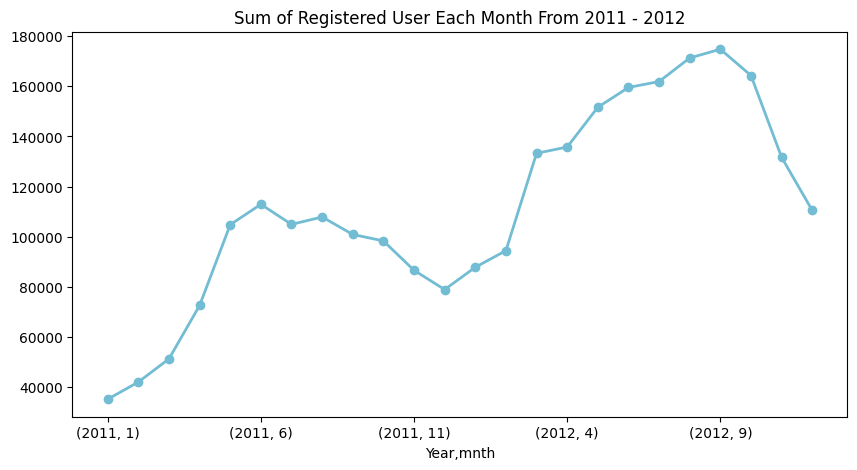

In [34]:
# Create visualization for the question
yr_mnth_df['registered'].plot(
    kind='line',
    figsize=(10, 5),
    marker='o',
    linewidth=2,
    color="#72BCD4",
    title='Sum of Registered User Each Month From 2011 - 2012')
plt.gca().spines[['top', 'right']].set_visible(True)

## Conclusion

- Sepeda paling **banyak dipinjam pada musim gugur sebanyak 1061129** dan paling **sedikit dipinjam pada musim semi sebanyak 471348**.
- Sepeda paling **banyak dipinjam pada pukul 17.00 sebanyak 336860** dan paling **sedikit dipinjam pada pukul 04.00 sebanyak 4428**
- Berdasarkan rata-rata, umumnya sepeda dipinjam pada **Hari Jumat dengan jumlah 4690**
- Performa peminjaman sepeda oleh pengguna yang terdaftar tiap bulannya berada di titik tertinggi pada **September 2012 yang mencapai 218573**. Kemudian, peminjaman sepeda oleh pengguna yang terdaftar **meningkat pesat pada Maret 2012 yang mencapai 61738**, tetapi mengalami **penurunan drastis pada Oktober 2012 dan terus mengalami penurunan hingga Desember 2012 yang menyentuh angka 123713**

## RFM Analysis

In [35]:
rfm_df = day_df.groupby(by="weekday_new", as_index=False).agg({
    "dteday": "max", # mengambil tanggal peminjaman terakhir
    "cnt": "sum" # menghitung jumlah peminjaman
})
rfm_df.columns = ["weekday", "max_order_timestamp", "frequency"]

# menghitung kapan terakhir pelanggan melakukan peminjaman (hari)
rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
recent_date = day_df["dteday"].dt.date.max()
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

rfm_df.drop("max_order_timestamp", axis=1, inplace=True)
rfm_df.head()

,weekday,frequency,recency
0,Friday,487790,3
1,Monday,455503,0
2,Saturday,477807,2
3,Sunday,444027,1
4,Thursday,485395,4


<ipython-input-36-098132313d9d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="recency", x="weekday", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
<ipython-input-36-098132313d9d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="frequency", x="weekday", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])


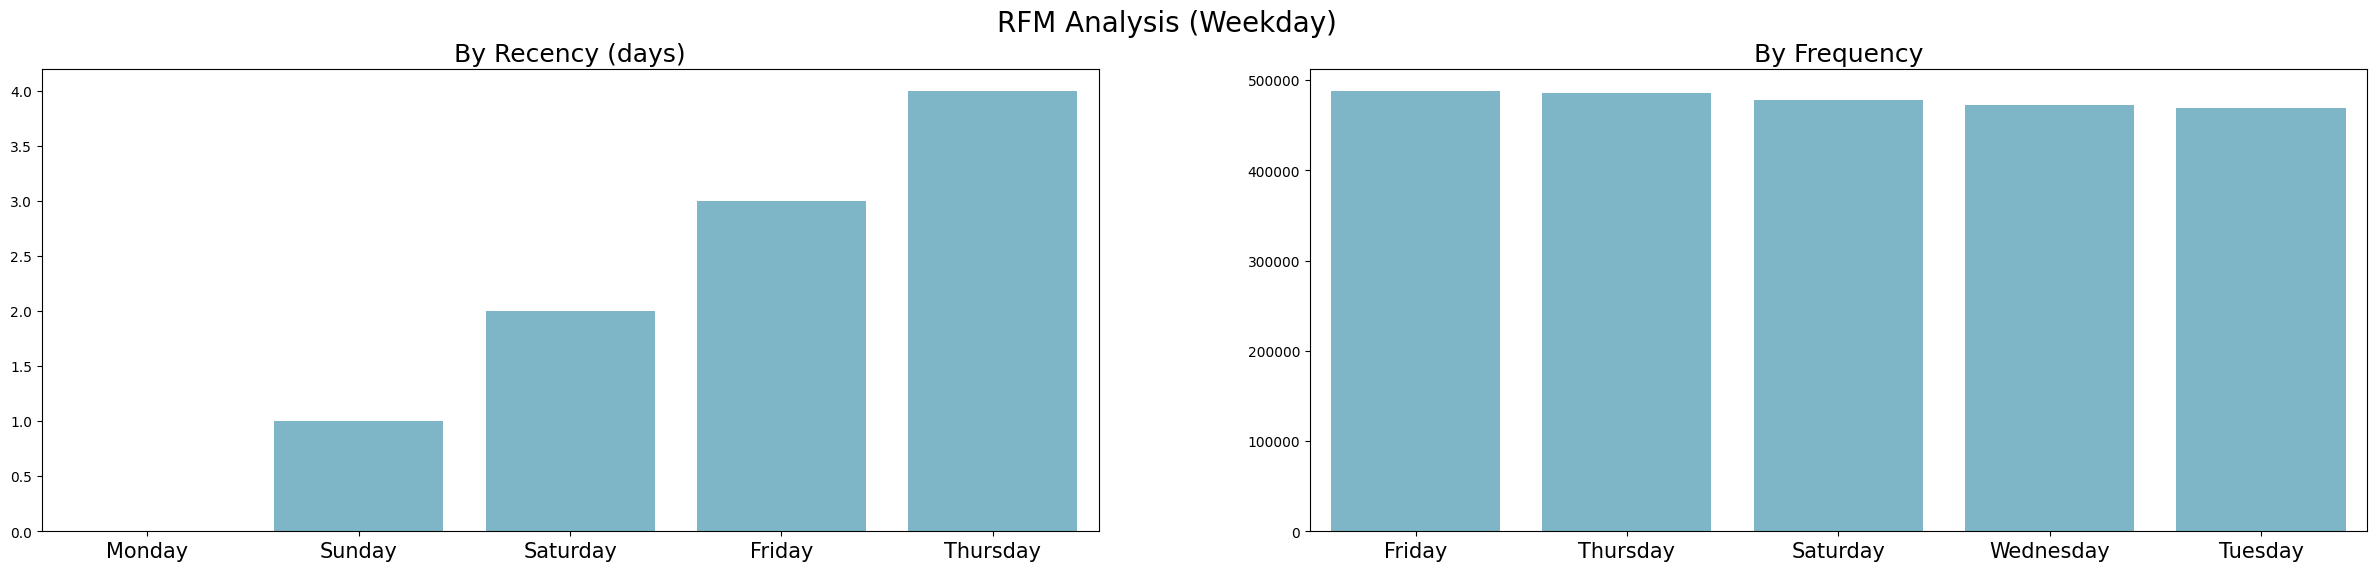

In [36]:
# Create visualization for the RFM Analysis
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))

colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

sns.barplot(y="recency", x="weekday", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=15)

sns.barplot(y="frequency", x="weekday", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15)

plt.suptitle("RFM Analysis (Weekday)", fontsize=20)
plt.show()

- Apabila pengguna terdaftar dan pengguna biasa digabung, maka akhir-akhir ini (recency) mereka lebih memilih meminjam sepeda pada **Hari Kamis**
- Apabila pengguna terdaftar dan pengguna biasa digabung, maka mereka lebih sering (frequency) meminjam sepeda pada **Hari Jumat**

## Feature Selection & Machine Learning

In [ ]:
new_day_df = day_df[['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 
                     'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']].copy()

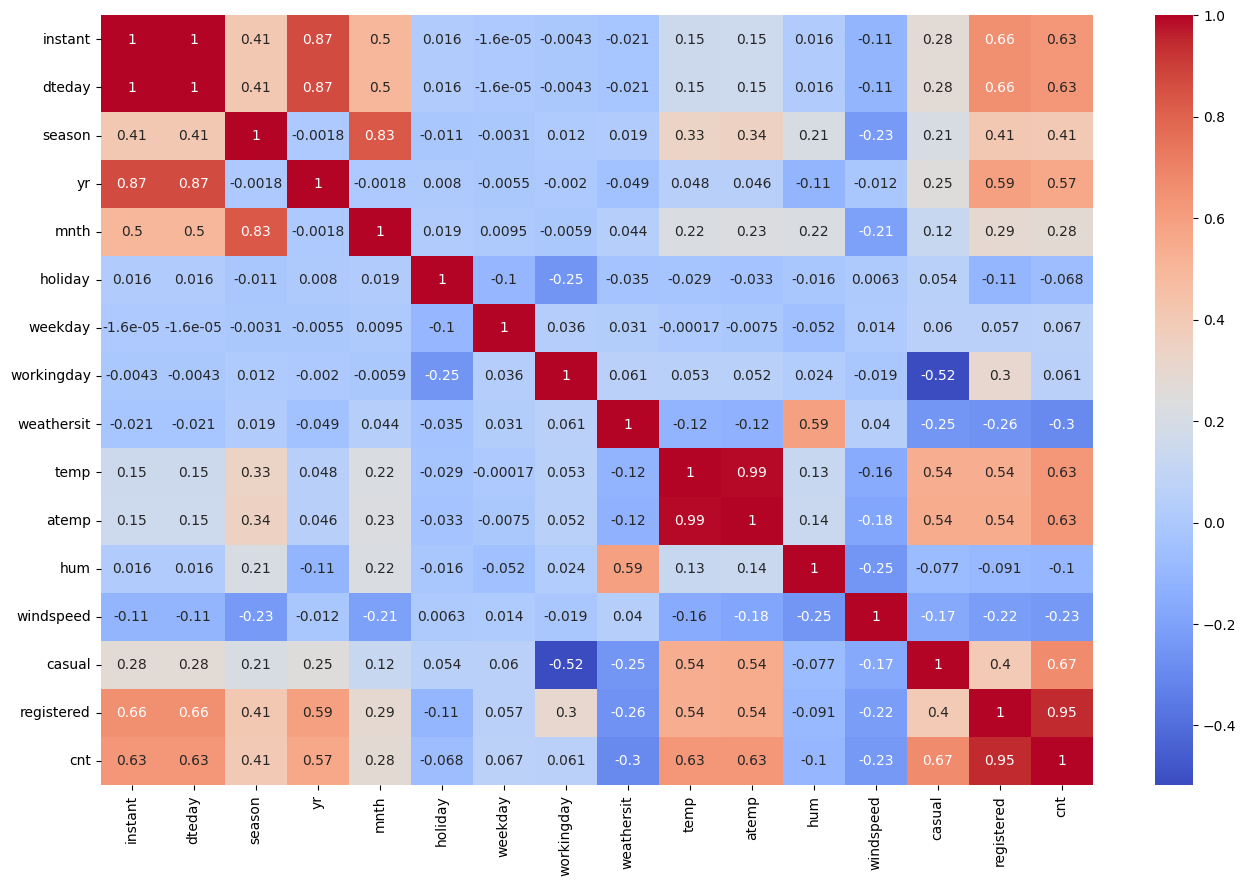

In [ ]:
#Plotting correlation heatmap to analyze the linearity between the variables in the dataframe 

plt.figure(figsize = (16, 10))
sns.heatmap(new_day_df.corr(), annot = True, cmap = 'coolwarm')
plt.show()

Karena fitur 'temp' dan 'atemp' memiliki tingkat korelasi yang sangat tinggi dan pada dasarnya kedua fitur tersebut memberikan informasi yang sama, maka hanya dipilih satu diantara dua fitur tersebut, yakni 'temp'. Fitur 'temp' dipilih karena fitur tersebut merupakan ukuran aktual dari temperatur, sedangkan fitur 'atemp' adalah ukuran temperatur yang dirasakan oleh tubuh dengan mempertimbangkan faktor-faktor lain, seperti kelembapan, angin, dan lain sebagainya.

In [ ]:
train_data, test_data = train_test_split(new_day_df.drop(['instant', 'dteday', 'yr', 'atemp', 'casual', 'registered'], axis=1), train_size=0.7, test_size=0.3, random_state=42)

Kolom 'instant', 'dteday', 'yr', 'atemp', 'casual', dan 'registered' di drop karena tidak digunakan dalam pembuatan model. Kolom 'instant', 'dteday', dan 'yr' di drop karena tidak memberikan kontribusi informasi yang signifikan. Kolom 'atemp' di drop dengan alasan seperti yang telah disampaikan sebelumnya. Kolom 'casual' dan 'registered' di drop karena telah diwakili oleh jumlah keseluruhan dari kedua kolom tersebut melalui kolom 'cnt' yang juga menjadi target dari pembuatan model regresi ini.

In [ ]:
scaler = MinMaxScaler()
numeric_var_a = ['season', 'mnth', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']
train_data[numeric_var_a] = scaler.fit_transform(train_data[numeric_var_a])
test_data[numeric_var_a] = scaler.transform(test_data[numeric_var_a])

train_data.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
223,0.666667,0.636364,0,0.833333,1,0.0,0.808938,0.431169,0.246270,0.540142
684,1.000000,0.909091,0,0.666667,1,0.5,0.327133,0.644589,0.311556,0.605336
685,1.000000,0.909091,0,0.833333,1,0.0,0.356208,0.545021,0.354588,0.635881
163,0.333333,0.454545,0,0.166667,1,0.0,0.717562,0.513852,0.675042,0.554026
394,0.000000,0.000000,0,0.166667,1,0.0,0.261716,0.416450,0.461387,0.385488


Dilakukan proses scaling agar data yang menjadi masukan konsisten, menghindari konvergensi yang lambat, akurasi yang buruk, dan ketidakstabilan numerik.

In [ ]:
y_train = train_data.pop('cnt')
X_train = train_data

print (y_train.head())
print (X_train.head())

223    0.540142
684    0.605336
685    0.635881
163    0.554026
394    0.385488
Name: cnt, dtype: float64
       season      mnth  holiday   weekday  workingday  weathersit      temp  \
223  0.666667  0.636364        0  0.833333           1         0.0  0.808938   
684  1.000000  0.909091        0  0.666667           1         0.5  0.327133   
685  1.000000  0.909091        0  0.833333           1         0.0  0.356208   
163  0.333333  0.454545        0  0.166667           1         0.0  0.717562   
394  0.000000  0.000000        0  0.166667           1         0.0  0.261716   

          hum  windspeed  
223  0.431169   0.246270  
684  0.644589   0.311556  
685  0.545021   0.354588  
163  0.513852   0.675042  
394  0.416450   0.461387  


In [ ]:
y_test = test_data.pop('cnt')
X_test = test_data

print (y_test.head())
print (X_test.head())

703    0.745503
33     0.135096
300    0.400338
456    0.677291
633    0.858022
Name: cnt, dtype: float64
       season      mnth  holiday   weekday  workingday  weathersit      temp  \
703  1.000000  1.000000        0  0.333333           1         0.0  0.519232   
33   0.000000  0.090909        0  0.666667           1         0.0  0.159278   
300  1.000000  0.818182        0  0.833333           1         0.5  0.338555   
456  0.333333  0.272727        0  0.000000           0         0.5  0.456929   
633  1.000000  0.727273        0  0.333333           1         0.0  0.611648   

          hum  windspeed  
703  0.762338   0.361994  
33   0.454884   0.609203  
300  0.608658   0.494040  
456  0.702597   0.357551  
633  0.592208   0.510362  


In [ ]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (511, 9), (511,)
Testing data shape: (220, 9), (220,)


In [ ]:
# Initialize and train the model
model = XGBRegressor(random_state=42)

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Predictions: [0.5799334  0.17834832 0.41389197 0.3756308  0.8574887  0.61786896
 0.21637979 0.31521872 0.7002089  0.509859   0.1311396  0.4714105
 0.7926253  0.55842394 0.3103017  0.37284136 0.5020928  0.78652185
 0.60381347 0.15943052 0.6174178  0.6931845  0.5717844  0.2147089
 0.2402364  0.5544618  0.22320126 0.74569887 0.19343087 0.50767773
 0.35074535 0.6822683  0.5886598  0.6683564  0.6280811  0.444313
 0.7199668  0.61662513 0.37829062 0.10540113 0.74801815 0.26879394
 0.67412585 0.6872185  0.6751982  0.2889159  0.5087387  0.5551153
 0.50537926 0.258538   0.48856056 0.24793841 0.26691583 0.7715508
 0.5931261  0.52687556 0.4554568  0.52937245 0.5309877  0.5918628
 0.5255276  0.5551316  0.1517617  0.5906279  0.7339901  0.49067318
 0.62901706 0.66912264 0.2644002  0.79183835 0.624197   0.5068295
 0.43591383 0.6034173  0.5118511  0.52564114 0.47118205 0.57380337
 0.08420381 0.45814365 0.09500828 0.3713926  0.56939626 0.14208694
 0.48440132 0.21546857 0.5057921  0.58008593 0.57615274 0

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")
print(f"R2 Score on Test Data: {r2}")

Mean Squared Error on Test Data: 0.02437805606711316
Mean Absolute Error on Test Data: 0.1266523782540096
R2 Score on Test Data: 0.5796566726149182


In [ ]:
# Set the minimum number of features to be selected
min_features_to_select = 1

# Set the cross-validation splitting strategy
cv = TimeSeriesSplit(5)

# Create a RFECV object using the estimator
rfecv = RFECV(model, min_features_to_select = min_features_to_select, cv=cv)

# Fit the data
rfecv.fit(X_train, y_train)

# Get integer index of the features selected
feature_index = rfecv.get_support(indices = True)

# Get a mask of the features selected
feature_mask = rfecv.support_

# Get selected feature names
feature_names = rfecv.get_feature_names_out()

# Get the number of features retained
feature_number = rfecv.n_features_

# Get results
results = pd.DataFrame(rfecv.cv_results_)

# Get RFECV score
rfecv_score = rfecv.score(X_train, y_train)

# Print feature number, names and score
print('Original feature number:', len(X_train.columns))
print('Optimal feature number:', feature_number)
print('Selected features:', feature_names)
print('Score:', rfecv_score)

Original feature number: 9
Optimal feature number: 9
Selected features: ['season' 'mnth' 'holiday' 'weekday' 'workingday' 'weathersit' 'temp'
 'hum' 'windspeed']
Score: 0.999544747634584


Dilakukan seleksi fitur dengan metode RFE dan didapatkan hasil bahwa dari 9 fitur yang menjadi masukan, semuanya adalah fitur penting yang berkontribusi terhadap banyaknya pengguna sepeda.

## Hyperparameter Tuning

In [ ]:
param_grid_1 = {
    'max_depth': range(1,11,1),
    'min_child_weight': range(1,11,1)
}

In [ ]:
model_a=XGBRegressor(learning_rate=0.01, random_state=42)

In [ ]:
grid_search_1 = GridSearchCV(estimator=model_a, param_grid=param_grid_1, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'max_depth': range(1, 11),
                         'min_child_weight': range(1, 11)},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_1.cv_results_, grid_search_1.best_params_, grid_search_1.best_score_

({'mean_fit_time': array([0.0981916 , 0.05522661, 0.06865287, 0.05894384, 0.05649233,
         0.06368723, 0.05850515, 0.05700264, 0.052707  , 0.05698485,
         0.08417568, 0.07268305, 0.08405766, 0.06877036, 0.06979957,
         0.06692967, 0.06652122, 0.06591916, 0.0653625 , 0.06801386,
         0.08182817, 0.0832159 , 0.08191562, 0.08075228, 0.0817286 ,
         0.08503461, 0.08115668, 0.07941742, 0.08479643, 0.08899746,
         0.10623183, 0.10022774, 0.10525069, 0.1018281 , 0.0985899 ,
         0.10422869, 0.1011724 , 0.10165443, 0.08950515, 0.0864809 ,
         0.12650766, 0.12440062, 0.12224855, 0.12255211, 0.11948767,
         0.11964197, 0.12144885, 0.11826806, 0.12390184, 0.12014704,
         0.16867452, 0.15503983, 0.15528102, 0.16180587, 0.14455113,
         0.14396749, 0.13662543, 0.13672805, 0.13267441, 0.13208551,
         0.19536662, 0.19125271, 0.21961884, 0.21122222, 0.16902981,
         0.16345496, 0.15503225, 0.15625129, 0.15296516, 0.14588852,
         0.241741

In [ ]:
param_grid_2 = {
    'gamma': [i/10.0 for i in range(0,5)]
}

In [ ]:
model_b=XGBRegressor(learning_rate=0.01, 
                     random_state=42,
                     max_depth=5, 
                     min_child_weight=6)

In [ ]:
grid_search_2 = GridSearchCV(estimator=model_b, param_grid=param_grid_2, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=6, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_2.cv_results_, grid_search_2.best_params_, grid_search_2.best_score_

({'mean_fit_time': array([0.15760312, 0.13466716, 0.09918566, 0.11062627, 0.10448666]),
  'std_fit_time': array([0.02911772, 0.03238646, 0.00505185, 0.01285853, 0.02231491]),
  'mean_score_time': array([0.01000152, 0.00974121, 0.00989256, 0.01249008, 0.01120086]),
  'std_score_time': array([0.00126327, 0.00092693, 0.0017105 , 0.00435095, 0.00193994]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-0.02831485, -0.02841893, -0.02950735, -0.03017534, -0.03078686]),
  'split1_test_score': array([-0.02475336, -0.0256201 , -0.02731789, -0.02818951, -0.02877544]),
  'split2_test_score': array([-0.03128832, -0.03184067, -0.03260558, -0.03294997, -0.03317211]),
  'split3_test_score': array([-0.02455362, -0.02515713, -0.02631544, -0.02703977, -0.02750781]),
  'sp

In [ ]:
param_grid_3 = {
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

In [ ]:
model_c=XGBRegressor(learning_rate=0.01, 
                     random_state=42,
                     max_depth=5, 
                     min_child_weight=6,
                     gamma=0.0)

In [ ]:
grid_search_3 = GridSearchCV(estimator=model_c, param_grid=param_grid_3, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_3.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, ma...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=6, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_3.cv_results_, grid_search_3.best_params_, grid_search_3.best_score_

({'mean_fit_time': array([0.15635777, 0.14262853, 0.13185859, 0.16211867, 0.13998628,
         0.13098087, 0.12581663, 0.13279767, 0.1428143 , 0.13443346,
         0.12940288, 0.14629593, 0.17978325, 0.13532677, 0.13945417,
         0.18880448]),
  'std_fit_time': array([0.04260072, 0.03267399, 0.00862874, 0.02988274, 0.01304232,
         0.00663027, 0.0092382 , 0.01010889, 0.02963943, 0.01429643,
         0.01083909, 0.01094162, 0.05235049, 0.00838919, 0.012221  ,
         0.03521243]),
  'mean_score_time': array([0.01060338, 0.00980034, 0.01090384, 0.01110616, 0.01036701,
         0.00980277, 0.00960145, 0.01000161, 0.0097939 , 0.00999932,
         0.00990396, 0.01160498, 0.01111307, 0.01019959, 0.01000185,
         0.01060214]),
  'std_score_time': array([0.00079993, 0.00074858, 0.00175584, 0.00102674, 0.00102756,
         0.00116385, 0.00049281, 0.00154879, 0.00074603, 0.00063039,
         0.00102621, 0.00135441, 0.0013668 , 0.00074762, 0.00126217,
         0.00101992]),
  'param_c

In [ ]:
param_grid_4 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

In [ ]:
model_d=XGBRegressor(learning_rate=0.01, 
                     random_state=42,
                     max_depth=5, 
                     min_child_weight=6,
                     gamma=0.0,
                     colsample_bytree=0.9, 
                     subsample=0.8)

In [ ]:
grid_search_4 = GridSearchCV(estimator=model_d, param_grid=param_grid_4, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_4.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=6, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_4.cv_results_, grid_search_4.best_params_, grid_search_4.best_score_

({'mean_fit_time': array([0.14717512, 0.13920431, 0.12906981, 0.11530156, 0.06767812]),
  'std_fit_time': array([0.02043495, 0.03289286, 0.01873909, 0.00657876, 0.00768102]),
  'mean_score_time': array([0.00995779, 0.01063666, 0.00919914, 0.0099031 , 0.01024332]),
  'std_score_time': array([0.00082009, 0.00103558, 0.00040091, 0.00101132, 0.00103864]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1.0, 100.0],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([-0.02811195, -0.0281889 , -0.02836556, -0.02930209, -0.05176477]),
  'split1_test_score': array([-0.02491551, -0.02487166, -0.02510799, -0.02837254, -0.05500612]),
  'split2_test_score': array([-0.03150951, -0.03150526, -0.03157058, -0.03197442, -0.05696405]),
  'split3_test_score': array([-0.02515906, -0.02515857, -0.02547351, -0.

In [ ]:
param_grid_5 = {
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
}

In [ ]:
model_e=XGBRegressor(learning_rate=0.01, 
                     random_state=42,
                     max_depth=5, 
                     min_child_weight=6,
                     gamma=0.0,
                     colsample_bytree=0.9, 
                     subsample=0.8,
                     reg_alpha=1e-05)

In [ ]:
grid_search_5 = GridSearchCV(estimator=model_e, param_grid=param_grid_5, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_5.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=6, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'reg_lambda': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_5.cv_results_, grid_search_5.best_params_, grid_search_5.best_score_

({'mean_fit_time': array([0.16557531, 0.16653461, 0.13529496, 0.14679651, 0.14606905]),
  'std_fit_time': array([0.03339218, 0.03442247, 0.00731496, 0.01126685, 0.04148979]),
  'mean_score_time': array([0.01131291, 0.01090512, 0.01040144, 0.00959311, 0.01050944]),
  'std_score_time': array([0.0021751 , 0.00112002, 0.00080212, 0.00135324, 0.00110414]),
  'param_reg_lambda': masked_array(data=[1e-05, 0.01, 0.1, 1.0, 100.0],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'reg_lambda': 1e-05},
   {'reg_lambda': 0.01},
   {'reg_lambda': 0.1},
   {'reg_lambda': 1},
   {'reg_lambda': 100}],
  'split0_test_score': array([-0.02753772, -0.02759908, -0.02761982, -0.02811195, -0.03570879]),
  'split1_test_score': array([-0.02474685, -0.0247537 , -0.02474502, -0.02491551, -0.03710016]),
  'split2_test_score': array([-0.03164331, -0.03161954, -0.03161522, -0.03150951, -0.03807342]),
  'split3_test_score': array([-0.02458723, -0.02458967, -0.0245777

In [ ]:
param_grid_6 = {
    'n_estimators': range(100,1100,100)
}

In [ ]:
model_f=XGBRegressor(learning_rate=0.01, 
                     random_state=42,
                     max_depth=5, 
                     min_child_weight=6,
                     gamma=0.0,
                     colsample_bytree=0.9, 
                     subsample=0.8,
                     reg_alpha=1e-05,
                     reg_lambda=1e-05)

In [ ]:
grid_search_6 = GridSearchCV(estimator=model_f, param_grid=param_grid_6, cv=5, 
                             scoring='neg_mean_squared_error')

In [ ]:
grid_search_6.fit(X_train, y_train, verbose=True)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=6, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'n_estimators': range(100, 1100, 100)},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_6.cv_results_, grid_search_6.best_params_, grid_search_6.best_score_

({'mean_fit_time': array([0.15328712, 0.30471473, 0.38202481, 0.51372795, 0.54255905,
         0.72084022, 0.7655869 , 0.88488588, 0.88272986, 0.97284598]),
  'std_fit_time': array([0.02810287, 0.0475492 , 0.04748048, 0.04208234, 0.02605996,
         0.07896997, 0.06407152, 0.06552553, 0.07903381, 0.02485006]),
  'mean_score_time': array([0.01029468, 0.01114497, 0.01076355, 0.01321616, 0.01140676,
         0.0125052 , 0.01274915, 0.01200299, 0.01247797, 0.0130477 ]),
  'std_score_time': array([1.11756162e-03, 7.75842229e-04, 2.97705657e-04, 3.40832653e-03,
         1.02275166e-03, 6.29386731e-04, 1.27249819e-03, 2.41921442e-06,
         4.48098179e-04, 1.08971078e-03]),
  'param_n_estimators': masked_array(data=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value=999999),
  'params': [{'n_estimators': 100},
   {'n_estimators': 200},
   {'n_estimators': 30

In [ ]:
best_model = grid_search_6.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Predictions:", y_pred_best)

Predictions: [0.5741265  0.18345073 0.44845426 0.41081205 0.7552974  0.64299774
 0.17720151 0.29277834 0.6922372  0.580388   0.17520308 0.4043336
 0.7114528  0.46529874 0.346236   0.35444683 0.42434472 0.77980894
 0.66667074 0.17795669 0.6584384  0.61605775 0.502475   0.21450599
 0.23888148 0.610882   0.24427511 0.7061206  0.2419419  0.4518994
 0.31442648 0.63199055 0.6283234  0.6864723  0.5623443  0.4504184
 0.688942   0.57402694 0.4048715  0.14106949 0.6625153  0.25218475
 0.6477184  0.6240429  0.61403215 0.22050188 0.5883733  0.5210881
 0.5838402  0.34078372 0.5311379  0.32601956 0.31213853 0.68659353
 0.6124182  0.65616876 0.4353448  0.501754   0.504611   0.57223636
 0.5909824  0.5845133  0.23744613 0.6493824  0.6175658  0.5818528
 0.6670333  0.6201832  0.22269422 0.7643728  0.569489   0.4538604
 0.4589832  0.6194002  0.47061187 0.5074537  0.47955167 0.6422647
 0.1673414  0.5800556  0.18201792 0.31433186 0.48289636 0.19253558
 0.50830626 0.30227005 0.5005981  0.53028804 0.46820596 

In [ ]:
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Mean Squared Error on Test Data: {mse_best}")
print(f"Mean Absolute Error on Test Data: {mae_best}")
print(f"R2 Score on Test Data: {r2_best}")

Mean Squared Error on Test Data: 0.02068690097398227
Mean Absolute Error on Test Data: 0.12419290050252395
R2 Score on Test Data: 0.6433021252904547


Dari hasil evaluasi berdasarkan tiga metrik yang digunakan, yakni MSE, MAE, dan R2 dapat diketahui bahwa setelah dilakukan hyperparameter tuning, model memiliki kinerja yang lebih baik.